In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

sns.set(style="ticks", context='poster')
az.style.use("arviz-darkgrid")
%matplotlib inline

RANDOM_SEED = 8927

The following software and libraries were used for simulation and visualisation:

In [3]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Wed Jul 05 2023

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.12.0

scipy     : 1.11.1
pandas    : 2.0.3
arviz     : 0.15.1
numpy     : 1.25.0
pymc      : 5.6.0
matplotlib: 3.7.1
seaborn   : 0.12.2



## A hierarchical model to accurately estimate the probability of developing Eu or St mouth form 

_author_: Ata Kalirad

Given the binary nature of mouth form in our favourite model organism, Pristionchus pacificus, and its relatives, it stands to reason that to estimate the probability of developing either of the two mouth forms, a Bernoulli process would be appropriate. However, what should you do with your experimental data if you counted different number of animals on different plates? 

An elegant solution is to construct a bayesian model where each plate is fitted with its own Bernoulli process, while all the plates, assuming that they belong to the same strain and the same treatment are connected together via hyperpriors, i.e., priors defined for hyperparametrs. While it might sound a bit intimidating, in practice it is quite seamless:

<img src="../supp_data/MF_model.png" alt="Drawing" style="width: 500px;"/>

In this model, datum $i$ from plate $j$ ($y_{i,j}$) is simulated as a Bernoulli process. Each plate gets its own Beta prior. 

Let's try this model on on a simple case with $3$ plates:

In [4]:
plate_1 = np.random.binomial(1, 0.5, 20)
plate_2 = np.random.binomial(1, 0.5, 25)
plate_3 = np.random.binomial(1, 0.5, 40)

In [5]:
def find_binom_heirarchical(G_samples, N_samples,t_tune=1000):
    group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
    data = []
    for i in range(0, len(N_samples)):
        data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
    with pm.Model() as model:
        #Hyperpriors
        μ = pm.Beta('μ', 1., 1.)
        κ = pm.HalfNormal('κ', 10)
        #prior
        θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
        #likelihood function
        y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
        # Sampling
        trace = pm.sample(tune=t_tune, draws=5000, target_accept=0.95, random_seed=RANDOM_SEED)
    return trace

In [6]:
G_samples = [np.sum(plate_1), np.sum(plate_2), np.sum(plate_3)] # number of Eu animals on each plate (I arbitrarily assinged 1 to Eu and 0 to St).
N_samples = [len(plate_1), len(plate_2), len(plate_3)] # the total number of animals counted per plate.
test = find_binom_heirarchical(G_samples, N_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, κ, θ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 18 seconds.


We first check the hyperpriors:

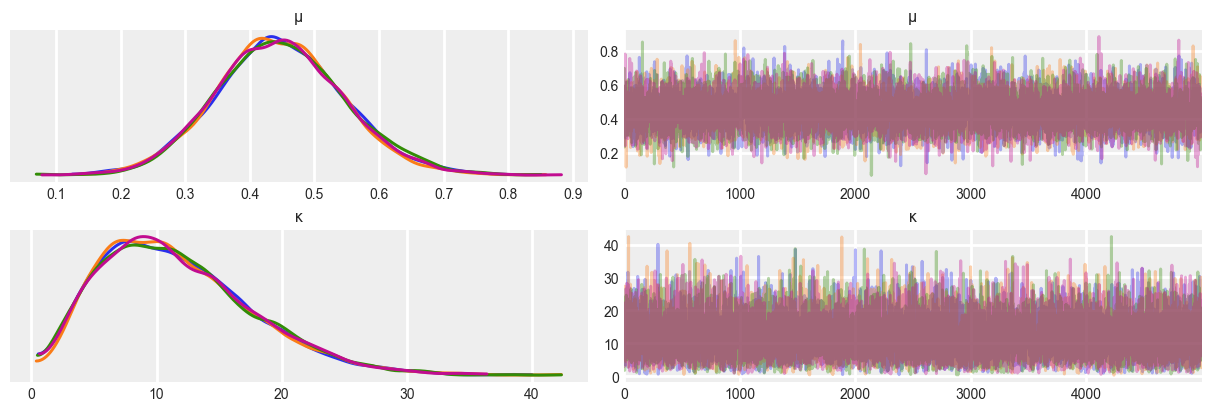

In [7]:
az.plot_trace(test, var_names=['μ', 'κ'], compact=False);

All the chains have converged, indicating that the model worked as intended.

We can focus on $\mu$, which is basically the mean probability of developing the Eu mouth form.

<Axes: title={'center': 'μ'}>

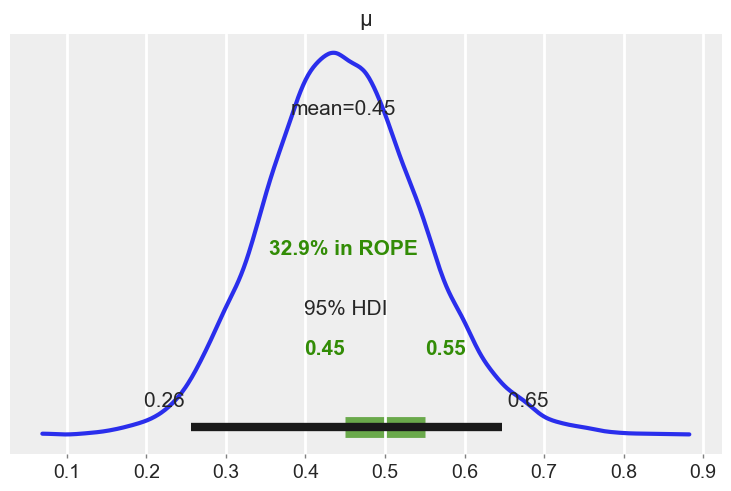

In [9]:
az.plot_posterior(test, var_names=['μ'], hdi_prob=0.95, rope=[0.45, 0.55])

We can also look at probability of developing the Eu mouth form on each plate:

array([<Axes: title={'center': 'θ\n0'}>, <Axes: title={'center': 'θ\n1'}>,
       <Axes: title={'center': 'θ\n2'}>], dtype=object)

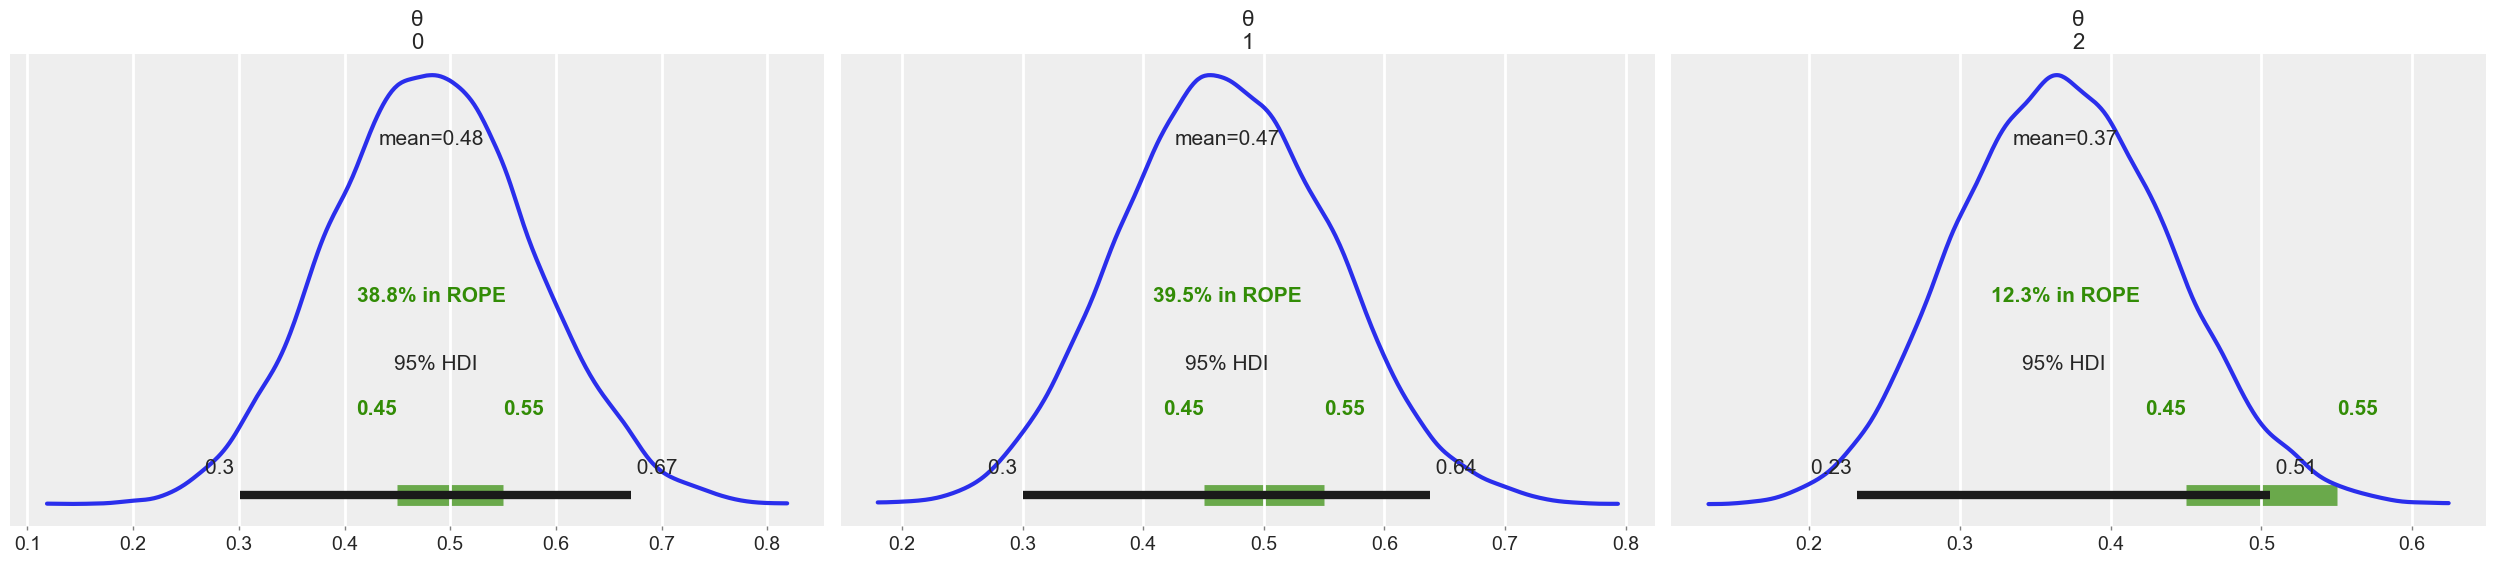

In [10]:
az.plot_posterior(test, var_names=['θ'], hdi_prob=0.95, rope=[0.45, 0.55])